In [2]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from scipy import stats
import pandas as pd

## Asset Simulation in a Risk-Neutral Framework

We assume that the assets follow a multi-dimensional Black–Scholes model under the risk-neutral measure:

$$
S_t^{m, i} = S_0^i e^{(r - \delta_i - \frac{\sigma_i^2}{2}) t  + \sigma_i W_t^i}, 
$$

where:

- $i = 1, \dots, d$ represents the $d$ different assets in the portfolio,
- $m = 1, \dots, M$ represents different independent simulated scenarios,
- $t \in [0, T]$ denotes the time evolution.

Each asset starts at an initial price $S_0^i \in (0, \infty)$ and evolves according to :

- $r \in \mathbb{R}$ : risk-free interest rate,
- $\delta_i \in [0, \infty)$ : dividend yield,
- $\sigma_i \in (0, \infty)$ : volatility of the asset,
- $W_t$ : $d$-dimensional Brownian motion.

### Understanding the Concept of a Scenario

A scenario $m$ corresponds to a possible evolution of a portfolio composed of $d$ assets over time. Each scenario is generated using the same parameters $r, \delta, \sigma$ but different realizations of the Brownian motion. 

By simulating multiple scenarios, we obtain a diverse set of possible asset price evolutions. The objective is to leverage these simulations to learn the optimal stopping time for an asset given its trajectory.

---

In [3]:
class Asset:
    """
    Simulates the price dynamics of a multi-dimensional asset using a geometric Brownian motion model.

    Attributes:
    -----------
    - s0 (float) : Initial asset price.
    - r (float) : Risk-free interest rate.
    - div (float) : Continuous dividend yield.
    - sigma (float) : Volatility of the asset.
    - T (int) : Time horizon for the simulation.
    - N (int) : Number of time steps in the discretized process.
    - M (int) : Number of Monte Carlo simulations.
    - d (int) : Number of assets (dimensions).
    - device (str) : Computational device ("cpu", "mps" or "cuda" for GPU acceleration).
    """

    def __init__(self, s0, r, div, sigma, T = 3, N = 9, M = 8192, d = 5, device = "cpu"):
        self.N = N
        self.M = M
        self.d = d
        self.T = T
        self.delta = T / N
        self.s0 = s0
        self.r = r
        self.div = div
        self.sigma = sigma
        self.device = device

    def brownian_paths(self, noise):
        """
        Generates Brownian motion paths based on standard normal noise.

        Parameters:
        -----------
        - noise (torch.Tensor) : A tensor of shape (N + 1, M, d) containing standard normal samples.

        Returns:
        --------
        - (torch.Tensor) : A tensor of shape (N + 1, M, d) representing Brownian motion paths.
        """
        dB = torch.zeros(noise.shape, device=self.device)
        dB[1:] = torch.sqrt(torch.tensor(self.delta, device=self.device)) * noise[1:]
        B = torch.cumsum(dB, axis = 0)

        return B

    def asset_paths(self, scenario_size=None):
        """
        Simulates asset price paths using the geometric Brownian motion model.

        Parameters:
        -----------
        - scenario_size (int) : The number of Monte Carlo simulations to generate. If None, uses the default M.

        Returns:
        --------
        - (torch.Tensor) A tensor of shape (N + 1, scenario_size, d) representing simulated asset paths.
        """
        M = scenario_size or self.M

        noise = torch.randn(size=(self.N + 1, M, self.d), device = self.device)
        B = self.brownian_paths(noise)
        tn = (torch.arange(self.N + 1, device = self.device) * self.delta)[:, None, None]
        S = self.s0 * torch.exp((self.r - self.div - 0.5 * self.sigma**2) * tn + self.sigma * B)

        return S


### Plotting the Asset Evolutions Through Time for Scenario 0

To better understand how asset prices evolve over time, we visualize the trajectories of all $d$ assets for a single scenario. Here, we choose scenario $0$ as an example.

Each trajectory follows a geometric Brownian motion, driven by the stochastic process equation introduced earlier. By plotting these paths, we can observe the variability in asset prices and how they evolve under different realizations of the Brownian motion.

The following plot shows the price evolution of all assets in scenario 0 over the given time horizon.

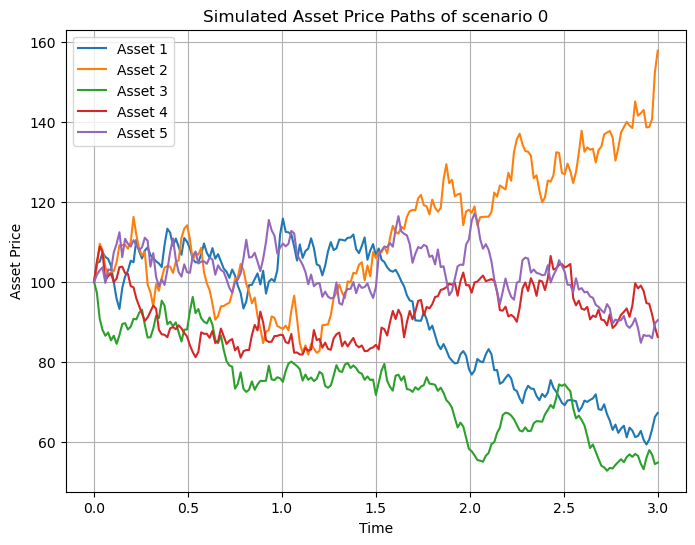

In [5]:
S  = Asset(s0 = 100,
           r = 0.05,
           div = 0.1,
           sigma = 0.2,
           T = 3,
           N = 200,
           M = 8192,
           d = 5)
paths = S.asset_paths()
tn = (torch.arange(S.N + 1) * S.delta)

plt.figure(figsize=(8, 6))
plt.plot(tn, paths[:, 0, :].detach().cpu(), label=[f"Asset {i+1}" for i in range(S.d)])

plt.xlabel("Time")
plt.ylabel("Asset Price")
plt.title("Simulated Asset Price Paths of scenario 0")
plt.legend()
plt.grid(True)
plt.show()


## Optimal Stopping Problem and Bermudan Max-Call Option

We consider optimal stopping problems of the form 
$
\sup_{\tau} \mathbb{E}[g(\tau, X_{\tau})],
$

where :

- $X = (X_n)_{n = 0}^N$ is an $\mathbb{R}^d$-valued discrete-time Markov process.
- The supremum is taken over all stopping times $\tau$ based on observations of $X$.

### Bermudan Max-Call Option Formulation

We analyze the Bermudan max-call option on multiple assets $S^1, ..., S^d$, with a payoff function

$$
\left( \max_{1 \leq i \leq d} S_t^i - K \right)^{+}.
$$

The option can be exercised at any point on a discrete time grid
$
0 = t_0 < t_1 < ... < t_N.
$

Its price is given by

$$
\sup_{\tau} \mathbb{E} \left[ e^{- r \tau} \max_{1 \leq i \leq d} S_t^i - K \right]^{+},
$$

where the supremum is taken over all stopping times $\tau$ that can only take values in $\{t_0, t_1, ..., t_N\}$.

To simplify notation, we define $X_n^i = S_{t_n}^i$ for $n = 0, ..., N$ and let $\mathcal{T}$ be the set of $X$-stopping times. The pricing problem can then be rewritten as

$$
\sup_{\tau} \mathbb{E}[g(\tau, X_{\tau})],
$$

where the reward function is

$$
g(n, x) = e^{- r t_n} \max_{1 \leq i \leq d} (x^i - K)^{+}.
$$

### Discretization and the Markov Assumption

This formulation applies to problems where stopping decisions can only be made at a finite number of times. However, in practice, most continuous-time stopping problems can be approximated by time-discretized versions.

The Markov assumption does not restrict generality but simplifies the presentation, as many real-world problems are already Markovian. Any optimal stopping problem can be transformed into a Markovian form by incorporating all relevant past information into the current state variable $X$ at the cost of increasing the dimensionality of the problem.

In [1]:
class MaxCallOption:
    """
    Represents a max call option on a multi-asset system.

    The option pays the difference between the maximum value of the assets
    and the strike price if positive, discounted at the risk-free rate.

    Attributes:
    -----------
    - asset (Asset) : The underlying asset object containing parameters such as volatility, risk-free rate, and time steps.
    - K (float) : The strike price of the option.
    - device (str) : Computational device ("cpu", "mps" or "cuda" for GPU acceleration).
    """

    def __init__(self, asset, K, device="cpu"):
        self.asset = asset
        self.K = K
        self.device = device

    def payoff(self, X, n = None, discounted = True):
        """
        Computes the discounted payoff of the max call option.

        The payoff is defined as:
            max(S_max - K, 0) * exp(-r * t_n)
        where S_max is the maximum value across all assets at each time step.

        Parameters:
        -----------
        - X (torch.Tensor) : Simulated asset price paths of shape (N + 1, M, d)
        - n (int) : If provided, returns the payoff at a specific time step `n`.
                    Otherwise, returns the full time series.

        Returns:
        --------
        - (torch.Tensor) The discounted payoff. Shape depends on `n`:
                        - If 'n' is None : returns shape (N + 1, M) (full time series).
                        - If 'n' is provided : returns shape (M) (payoff at time `n`).
        """

        max_value = torch.max(X, dim = -1)[0]
        payoff_value = torch.relu(max_value - self.K)
        if discounted :
            tn = (torch.arange(X.shape[0], device=self.device) * self.asset.delta)[:, None]
            discount_factor = torch.exp(-self.asset.r * tn)
            payoff_value = discount_factor * payoff_value

        return payoff_value[n] if n is not None else payoff_value


### Evolution of the Bermudan Max Call Option Over Time for Scenario 0

Given the simulated asset paths, we visualize how the payoff evolves over time in a single scenario. 

- Each **colored line** represents the trajectory of a different asset within the portfolio. The lower opacity highlights the general trend of asset price evolution.
- The **red line** represents the maximum price reached at each time step across all assets.
- The **dashed brown line** corresponds to the payoff of the max-call option, which depends on the highest observed asset price at each time step.

This visualization provides insights into how the option's value is influenced by the underlying asset behavior over time.

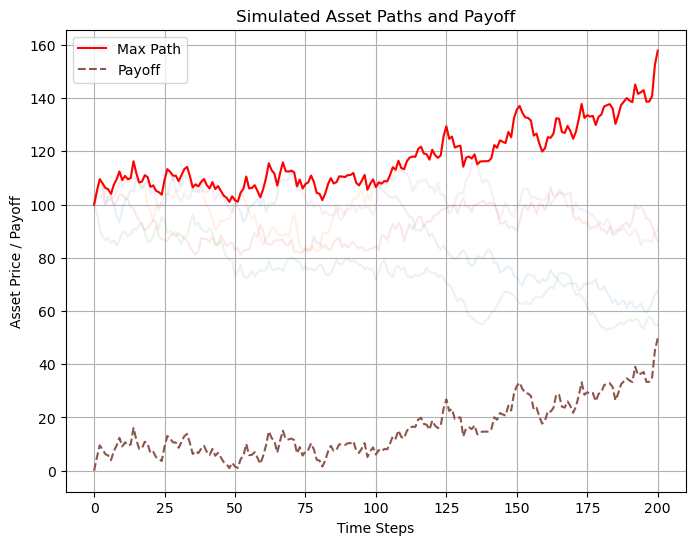

In [7]:
option_S = MaxCallOption(S, K = 100)
payoffs = option_S.payoff(paths)


path_0 = paths[:, 0]
max_path = torch.max(path_0, axis = -1)[0]

plt.figure(figsize=(8, 6))

for i in range(path_0.shape[1]):
    if torch.equal(path_0[:, i], max_path):
        plt.plot(path_0[:, i].detach().cpu(), alpha=1, label=f"Path {i} (max)")
    else:
        plt.plot(path_0[:, i].detach().cpu(), alpha=0.1)

plt.plot(max_path.detach().cpu(), color='red', label="Max Path")
plt.plot(payoffs[:, 0].detach().cpu(), label="Payoff", linestyle='--')

plt.legend()
plt.title("Simulated Asset Paths and Payoff")
plt.xlabel("Time Steps")
plt.ylabel("Asset Price / Payoff")
plt.grid(True)
plt.show()

## Neural Network Architecture

The neural network function $F^{\theta}$ is parameterized by $\theta \in \mathbb{R}^q$, which consists of:

- Weight matrices:
  - $A_1 \in \mathbb{R}^{d \times q_1}$
  - $A_2 \in \mathbb{R}^{q_2 \times q_1}$
  - $A_3 \in \mathbb{R}^{1 \times q_2}$
- Bias vectors:
  - $b_1 \in \mathbb{R}^{q_1}$
  - $b_2 \in \mathbb{R}^{q_2}$
  - $b_3 \in \mathbb{R}$

Each affine transformation in the network follows the form

$$
a_i^{\theta}(x) = A_i x + b_i.
$$

where the total number of parameters is $q = 1 + q_1 + q_2$.

### Feedforward Neural Network Definition

The neural network $F^{\theta} : \mathbb{R}^d \to (0,1)$ is defined as

$$
F^{\theta} = \psi \circ a_3^{\theta} \circ \varphi_{q_2} \circ a_2^{\theta} \circ \varphi_{q_1} \circ a_1^{\theta}
$$

where :

- $\varphi_{q_1}$ and $\varphi_{q_2}$ are activation functions (typically ReLU or another non-linearity).
- $\psi : \mathbb{R} \to (0,1)$ is the standard logistic (sigmoid) function, applied only during training to produce probability outputs.

### Stabilizing Training with Batch Normalization

To enhance training stability, batch normalization was employed. This technique normalizes intermediate activations across batches, reducing internal covariate shifts and leading to faster and more stable convergence.

In [8]:
class Network(nn.Module):
    """
    A simple feedforward neural network with two hidden layers, batch normalization,
    and ReLU activation functions, followed by a final sigmoid activation.

    Attributes:
    -----------
    - d (int) : Input feature dimension.
    - q1 (int) : Number of neurons in the first hidden layer.
    - q2 (int) : Number of neurons in the second hidden layer.
    """

    def __init__(self, d, q1, q2):
        super().__init__()
        self.hidden1 = nn.Linear(d, q1)   # First hidden layer
        self.bn1 = nn.BatchNorm1d(q1)     # Batch normalization for stability
        self.act1 = nn.ReLU()             # Activation function

        self.hidden2 = nn.Linear(q1, q2)  # Second hidden layer
        self.bn2 = nn.BatchNorm1d(q2)     # Batch normalization
        self.act2 = nn.ReLU()             # Activation function

        self.output = nn.Linear(q2, 1)    # Output layer

    def forward(self, x):
        """
        Forward pass through the network.

        Parameters:
        -----------
        - x (Tensor) : Input tensor of shape (M, d), where M is the batch size.

        Returns:
        - (Tensor) : Output tensor of shape (M), with values in the range (0,1) after the sigmoid activation.
        """
        x = self.act1(self.bn1(self.hidden1(x)))
        x = self.act2(self.bn2(self.hidden2(x)))
        x = self.output(x)
        return x.squeeze(-1) # originally we have shape (M,1) so we squeeze it to get (M)

## Training the Neural Network

For a given $x \in \mathbb{R}^q$, the function $F^{\theta}(x)$ is continuous and almost everywhere differentiable in $\theta$. Our objective is to determine an optimal parameter $\theta_n \in \mathbb{R}^q$ such that

$$
\mathbb{E}[(g(n, X_n) F^{\theta_n}(X_n) + g(\tau_{n+1}, X_{\tau_{n+1}})(1 - F^{\theta_n}(X_n)))]
$$

is as close as possible to the supremum:

$$
\sup_{\theta \in \mathbb{R}^q} \mathbb{E}[ g(n, X_n) F^{\theta}(X_n) + g(\tau_{n+1}, X_{\tau_{n+1}})(1 - F^{\theta}(X_n))].
$$

### Hard Stopping Decision

Once the optimal $\theta_n$ has been obtained, we define the stopping function $f^{\theta_n} : \mathbb{R}^d \to \{0, 1\}$ as:

$$
f^{\theta_n} = \mathbb{1}_{[0, \infty)} \circ a_3^{\theta_n} \circ \varphi_{q_2} \circ a_2^{\theta_n} \circ \varphi_{q_1}^{\theta_n} \circ a_1^{\theta_n},
$$

where $\mathbb{1}_{[0, \infty)}$ is the indicator function of $[0, \infty)$. 

The key difference between $F^{\theta_n}$ and $f^{\theta_n}$ lies in the final activation function:
- $F^{\theta_n}$ produces a **soft stopping probability** in $(0,1)$, using a sigmoid function.
- $f^{\theta_n}$ produces a **hard stopping decision** in $\{0,1\}$ by removing the sigmoid and directly thresholding at $0$.

Thus, after training, we consider stopping when $f^{\theta_n} > 0$.

### Simulating Rewards Under the Stopping Policy

If at time step $n$, we apply the **soft** stopping decision $F^{\theta}$, and thereafter follow the **hard** decisions $f^{\theta_{n+1}},..., f^{\theta_{N}}$, then the realized reward along the $k$-th simulated path is

$$
r_n^k(\theta) = g(n, x_n^k)F^{\theta}(x_n^k) + g(\tau_{n + 1}^k, x_{\tau_{n + 1}^k}^k) (1 - F^{\theta}(x_n^k)).
$$

### Training Process

The authors proposed to conduct $3,000 + d$ training steps, where each step involved generating a batch of 8,192 simulated paths of $(X_n)_{n = 0}^N$.

Moreover, they observed that even though $g(n, X_n)$ does not contain any additional information beyond $X_n$, the training was more effective when they used

$$
(Y_n)_{n = 0}^N = (X_n, g(n, X_n))_{n = 0}^N
$$

instead of using $(X_n)_{n = 0}^N$ alone. This additional dimension helped the neural network learn a more robust stopping strategy.

## Lower Bound Estimation

Once the stopping decisions $f^{\theta_n}$ have been trained, the corresponding stopping time $\tau^{\theta}$ provides a lower bound:

$$
L = \mathbb{E}[g(\tau^{\theta}, X_{\tau^{\theta}})]
$$

for the optimal value:

$$
V_0 = \sup_{\tau \in \mathcal{T}} \mathbb{E}[g(\tau, X_{\tau})].
$$

### Monte Carlo Estimation of the Lower Bound

To estimate $L$, we generate a new set of **independent** realizations $(y_n^k)_{n = 0}^N$, for $k = 1, ..., K_L$, of the process $(X_n)_{n = 0}^N$.

Using these simulations, we compute the Monte Carlo estimate of the lower bound:

$$
\hat{L} = \frac{1}{K_L} \sum_{k = 1}^{K_L} g(\tau^k, y_{\tau^k}^k).
$$  

This estimate $\hat{L}$ is unbiased and by the law of large numbers, as the number of samples increases ($K_L \to \infty$), the estimate $\hat{L}$ converges to the true lower bound $L$.

## Upper Bound Estimation

The upper bound is a little more tricky and is derived using the **Snell envelope** approach, leveraging the fact that

$$
H_n = \text{ess sup}_{\tau \in \mathcal{T}} \mathbb{E}[g(\tau, X_{\tau}) \mid \mathcal{F}_n]
$$

is the smallest supermartingale with respect to the filtration $(\mathcal{F}_n)_{n=0}^N$ that dominates $(g(n, X_n))_{n=0}^N$.

### Doob-Meyer Decomposition

The Doob-Meyer decomposition expresses $H_n$ as:

$$
H_n = H_0 + M_n^H - A_n^H,
$$

where:
- $M^H$ is a **martingale** with respect to $(\mathcal{F}_n)$.
- $A^H$ is a **non-decreasing predictable process**.

### Upper Bound Inequalities

In the paper it is shown that for a sequence of random variables $(\epsilon_n)_{n=0}^N$ on $(\Omega, \mathcal{F}, \mathbb{P})$, we have:

$$
V_0 \geq \mathbb{E} \left[\max_{0 \leq n \leq N} \big( g(n, X_n) - M_n^H - \epsilon_n \big) \right] 
+ \mathbb{E} \left[\min_{0 \leq n \leq N} (A_n^H + \epsilon_n) \right].
$$

Moreover, if $\mathbb{E}[\epsilon_n \mid \mathcal{F}_n] = 0$ for all $n \in \{0, ..., N\}$, then

$$
V_0 \leq \mathbb{E} \left[\max_{0 \leq n \leq N} (g(n, X_n) - M_n - \epsilon_n) \right]
$$

for every $(\mathcal{F}_n)$-martingale $(M_n)_{n=0}^N$ starting at $M_0 = 0$.

### Constructing a Martingale Close to $M^H$

The upper bound is **tight** when choosing $M = M^H$ and $\epsilon = 0$. Therefore, we construct a martingale that approximates $M^H$ using the optimal stopping time.

The martingale component of $H_n$ is given by

$$
M_0 = 0,
$$

and for $n \geq 1$:

$$
M_n - M_{n-1} = H_n - \mathbb{E}[H_n \mid \mathcal{F}_{n-1}].
$$

By substituting the stopping function $f^{\theta_n}$, this simplifies to

$$
M_n - M_{n-1} = f^{\theta_n}(X_n) g(n, X_n) + (1 - f^{\theta_n}(X_n)) C_n - C_{n-1}.
$$

where $C_n$ is the **continuation value**:

$$
C_n = \mathbb{E}[g(\tau_{n+1}, X_{\tau_{n+1}}) \mid \mathcal{F}_n] = \mathbb{E}[g(\tau_{n+1}, X_{\tau_{n+1}}) \mid X_n].
$$

### Estimating the Continuation Value

To estimate $C_n$, we generate a new set of **independent realizations** $(z_n)_{0 \leq n \leq N}^{1 \leq k \leq K_u}$.

For each $z_n^k$, we simulate $J$ continuation paths:

$$
\tilde{z}_{m}^{i,k,j} = z_n^{i, k} e^{(r - \delta_i - \frac{\sigma_i^2}{2})(m - n)\Delta t + \sigma_i(v_{n+1}^{i,k,j} + ... + v_{m}^{i,k,j})},
$$

for $m = n+1, ..., N$, where $(v_n)_{1 \leq n \leq N}$ represents the Brownian motion increments:

$$
v_n^{i,k,j} = W_{t_n} - W_{t_{n-1}}.
$$

The continuation value is then approximated as

$$
C_n^k = \frac{1}{J} \sum_{j=1}^{J} g(\tau_{n+1}^{k, j}, \tilde{z}_{\tau_{n+1}^{k, j}}^{k,j}),
$$

for $n = 0, ..., N-1$. This gives the martingale increments

$$
\Delta M_n^k = f^{\theta_n}(z_n^k) g(n, z_n^k) + (1 - f^{\theta_n}(z_n^k)) C_n^k - C_{n-1}^k.
$$

Thus, the martingale process is computed as

$$
M_n^k = \sum_{m=1}^{n} \Delta M_m^k, \quad M_0^k = 0.
$$

### Monte Carlo Approximation of the Upper Bound

The Monte Carlo estimator for the upper bound is

$$
\hat{U} = \frac{1}{K_u} \sum_{k=1}^{K_u} \max_{0 \leq n \leq N} (g(n, z_n^k) - M_n^k).
$$

By the law of large numbers, as $K_u \to \infty$, the estimate $\hat{U}$ converges to the true upper bound:

$$
U = \mathbb{E} \left[\max_{0 \leq n \leq N} (g(n, X_n) - M_n - \epsilon_n) \right].
$$

In [9]:
class DeepOptimalStopping:
    """
    Implements the Deep Optimal Stopping algorithm for pricing American-style options
    using a deep learning-based approach.

    Attributes:
    -----------
    - asset (Asset) : The underlying asset object containing price dynamics.
    - contract (Option) : The option contract defining the payoff function.
    - K_lower (int) : Number of Monte Carlo simulations for lower bound estimation (default 4,096,000).
    - K_upper (int) : Number of Monte Carlo simulations for upper bound estimation (default 1,024).
    - J (int) : Number of samples used for continuation value estimation (default 16,384).
    - device (str) : Computational device ("cpu", "mps" or "cuda" for GPU acceleration).
    """

    def __init__(self, asset, contract, K_lower = 4_096_000, K_upper = 1024, J = 16_384, device = "cpu"):
        self.asset = asset
        self.contract = contract
        self.K_lower = K_lower
        self.K_upper = K_upper
        self.J = J
        self.device = device

        # Ensure device consistency across objects
        self.contract.device = device
        self.asset.device = device

        self.thetas = None

    def augmented_process(self, X, payoffs):
        """
        Constructs an augmented process by appending the option payoffs to the asset paths.

        Parameters:
        -----------
        - X (torch.Tensor) : Asset paths of shape (N + 1, M, d).
        - payoffs (torch.Tensor) : Payoff values of shape (N + 1, M).

        Returns:
        --------
        - (torch.Tensor) : Augmented process of shape (N + 1, M, d + 1).
        """
        return torch.cat((X, payoffs[..., None]), dim = -1)

    def initialize_model(self):
        """
        Initializes a neural network.

        Returns:
        --------
        - (Network) : A neural network model with input dimension d + 1 and hidden layers of size d + 40.
        """
        input_dim = self.asset.d + 1
        hidden_dim = self.asset.d + 40
        return Network(input_dim, hidden_dim, hidden_dim).to(self.device)

    def train(self, training_steps = None, batch_size = 8192):
        """
        Trains the deep neural networks.

        Parameters:
        -----------
        - training_steps (int) : Number of training iterations (default is d + 3000).
        - batch_size (int) : Batch size for training (default 8192).
        """
        self.thetas = [self.initialize_model() for _ in range(self.asset.N)]
        optimizers = [torch.optim.Adam(self.thetas[n].parameters(), lr = 0.001) for n in range(self.asset.N)]

        training_steps = training_steps or (self.asset.d + 3000)

        for step in tqdm(range(training_steps), desc = "Training steps"):
            X = self.asset.asset_paths(scenario_size = batch_size)
            payoff = self.contract.payoff(X)
            Y = self.augmented_process(X, payoff)
            payoff_opt = payoff[-1]

            for n in range(Y.shape[0] - 2, -1, -1):
                F = torch.sigmoid(self.thetas[n](Y[n]))
                loss_val = -torch.mean(F * payoff[n] + (1 - F) * payoff_opt)

                exercise_now = F > 0.5
                # this is equivalent to payoff_opt[exercice_now] = payoff[n, exercice_now]
                payoff_opt = torch.where(exercise_now, payoff[n], payoff_opt)

                optimizers[n].zero_grad()
                loss_val.backward()
                optimizers[n].step()

    def compute_exercise_policy(self, X, n = 0):
        """
        Computes the optimal stopping policy using trained networks backward from N - 1 to n.

        Parameters:
        -----------
        - X (torch.Tensor) : Asset paths of shape (N + 1, M, d).
        - n (int) : Starting time step (default 0).

        Returns:
        --------
        - (torch.Tensor) : Optimal stopping payoffs of shape (M).
        """
        payoff = self.contract.payoff(X)
        Y = self.augmented_process(X, payoff)

        payoff_opt = payoff[-1]

        for m in range(Y.shape[0] - 2, n - 1, -1):
            f_theta = self.thetas[m](Y[m])
            exercise_now = f_theta > 0
            payoff_opt = torch.where(exercise_now, payoff[m], payoff_opt)

        return payoff_opt

    def get_lowerbound(self):
        """
        Computes a lower bound for the option value using the exercise policy.

        Returns:
        --------
        - mean_payoff (float) : Expected payoff estimate.
        - variance (float) : Variance of the estimates.
        """
        X = self.asset.asset_paths(scenario_size = self.K_lower)
        payoff_opt_lower = self.compute_exercise_policy(X).cpu().numpy()
        mean_payoff = payoff_opt_lower.mean()
        variance = np.var(payoff_opt_lower, ddof = 1)

        return mean_payoff, variance

    def get_continuation_values(self, z):
        """
        Estimates the continuation values using Monte Carlo simulations.

        This function generates multiple future paths for each state z_n and computes the expected optimal payoff at future time steps.

        Parameters:
        -----------
        - z (torch.Tensor) : Simulated asset paths of shape (N + 1, K_upper, d).

        Returns:
        --------
        - (torch.Tensor): Continuation values of shape (N + 1, K_upper), representing the expected optimal payoff for each time step and each scenario.
        """
        C = torch.zeros((self.asset.N + 1, self.K_upper), device = self.device)

        noise = torch.normal(0, 1, size = (self.asset.N + 1, self.K_upper * self.J, self.asset.d), device = self.device)  # Shape : (N + 1, K_upper * J, d)
        B = self.asset.brownian_paths(noise)
        v = (B[1:] - B[:-1]).to(self.device) # Shape : (N, K_upper * J, d)

        for n in range(self.asset.N):
            time_diff = ((torch.arange(n + 1, self.asset.N + 1, device = self.device) - n) * self.asset.delta)[:, None, None]

            # Repeat current state z_n for J scenarios
            z_n = z[n].repeat((self.J, 1)) # Shape : (K_upper * J, d)
            z_tilde = z_n * torch.exp(
                (self.asset.r - self.asset.div - 0.5 * self.asset.sigma ** 2) * time_diff
                + self.asset.sigma * torch.cumsum(v[n:], dim = 0)
            )  # Shape : (N - n , K_upper * J, d)
            payoff_opt_C = self.compute_exercise_policy(z_tilde, n) # Shape : (K_upper * J)
            payoff_opt_C = payoff_opt_C.reshape((self.J, self.K_upper)) # Shape : (J, K_upper)

            C[n] = torch.mean(payoff_opt_C, dim = 0) # Shape : (K_upper)

        return C

    def get_martingale(self, X, payoffs, C):
        """
        Computes the martingale process for the option pricing.

        This function constructs the martingale representation by adjusting
        continuation values and stopping decisions.

        Parameters:
        -----------
        - X (torch.Tensor) : Simulated asset paths of shape (N + 1, K_upper, d).
        - payoffs (torch.Tensor) : Payoff values of shape (N + 1, K_upper).
        - C (torch.Tensor) : Continuation values of shape (N + 1, K_upper)

        Returns:
        --------
        - (torch.Tensor) : Martingale process M of shape (K_upper).
        """
        Y = self.augmented_process(X, payoffs)

        delta_M = torch.zeros((self.asset.N + 1, self.K_upper), device = self.device)

        for n in range(1, self.asset.N):
            f_theta = self.thetas[n](Y[n])
            exercise_now = f_theta > 0
            delta_M[n] = (
                exercise_now * payoffs[n] + torch.logical_not(exercise_now) * C[n] - C[n - 1]
            )
        delta_M[self.asset.N] = payoffs[self.asset.N]

        M = torch.cumsum(delta_M, dim = 0)

        return M

    def get_upperbound(self):
        """
        Computes an upper bound for the option value using the continuation values.

        Returns:
        --------
        - mean_payoff (float) : Expected payoff estimate.
        - variance (float) : Variance of the estimates.
        """
        z = self.asset.asset_paths(scenario_size = self.K_upper)
        payoffs = self.contract.payoff(z)

        C = self.get_continuation_values(z)
        M = self.get_martingale(z, payoffs, C)

        upper_bound_values = torch.max(payoffs - M, dim = 0)[0].cpu().numpy()

        mean_payoff = upper_bound_values.mean()
        variance = np.var(upper_bound_values, ddof=1)

        return mean_payoff, variance

    def get_price(self, confidence_level: float = 0.95):
        """
        Computes the estimated option price and its confidence interval.

        Parameters:
        -----------
        - confidence_level (float) : Confidence level for the interval (default 95%).

        Prints:
        -------
        The estimated option price with its confidence interval.
        """
        print("Calculating the option price using Deep Optimal Stopping...")

        mean_lower, var_lower = self.get_lowerbound()
        mean_upper, var_upper = self.get_upperbound()
        point_estimate = (mean_lower + mean_upper) / 2

        alpha = 1 - confidence_level
        quantile = stats.norm.ppf(1 - alpha / 2)

        ci_lower = mean_lower - quantile * np.sqrt(var_lower / self.K_lower)
        ci_upper = mean_upper + quantile * np.sqrt(var_upper / self.K_upper)

        print(f"\n=== Option Pricing Results ===")
        print(f"Lower Bound Estimate : {mean_lower:.6f} ± {quantile * np.sqrt(var_lower / self.K_lower):.6e}")
        print(f"Upper Bound Estimate : {mean_upper:.6f} ± {quantile * np.sqrt(var_upper / self.K_upper):.6e}")
        print(f"Estimated Price      : {point_estimate:.6f}")
        print(f"Confidence Level     : {confidence_level*100:.1f}%")
        print(f"Confidence Interval  : [{ci_lower:.6f}, {ci_upper:.6f}]\n")

## Price Simulations and Computational Trade-offs

The current implementation is not fully optimized for computing the upper bound because it requires running

$$
K_{\text{upper}} \times J \times d
$$

normal simulations. 

This significantly increases computational complexity, making it challenging to use a very large value for $J$. As a result, the upper bound can sometimes be underestimated due to the limited number of Monte Carlo samples.

### Balancing Efficiency and Accuracy

To balance computational efficiency and accuracy, we reduced the number of training steps from

$$
3000 + d \quad \text{to} \quad 300.
$$

Despite this reduction, the model still converges to satisfactory results, while significantly lowering overall computation time.

### Interpretation of Results

Due to these computational constraints, in some cases, the upper bound appears slightly lower than the lower bound. However, this discrepancy is an artifact of the limited Monte Carlo estimation and does not invalidate the approach.

Overall, the results remain highly convincing and closely align with those reported in the original paper.


In [11]:
S  = Asset(s0 = 100,
           r = 0.05,
           div = 0.1,
           sigma = 0.2,
           T = 3,
           N = 9,
           M = 8192,
           d = 3)
contract = MaxCallOption(S, K = 100)
model = DeepOptimalStopping(S,
                            contract,
                            K_lower = 4_960_000,
                            K_upper = 1024,
                            J = 1684 * 5,
                            device = "cuda")
model.train(training_steps = 3000)
model.get_price(confidence_level = 0.95)

Training steps: 100%|██████████| 3000/3000 [00:57<00:00, 52.46it/s]


Calculating the option price using Deep Optimal Stopping...

=== Option Pricing Results ===
Lower Bound Estimate : 18.571428 ± 1.547289e-02
Upper Bound Estimate : 18.811329 ± 1.189687e-01
Estimated Price      : 18.691380
Confidence Level     : 95.0%
Confidence Interval  : [18.555955, 18.930298]



In [12]:
def get_df_values(asset, contract, d_list = [2, 3, 5], s0_list = [90, 100, 110], device = "cpu"):
    """
    Computes option price estimates and confidence intervals for different dimensions (d)
    and initial prices (s0) using Deep Optimal Stopping.

    Parameters:
    -----------
    - asset (Asset) : The underlying asset object containing price dynamics.
    - d_list (list) : List of asset dimensions to test (default: [2, 3, 5]).
    - s0_list (list) : List of initial prices to test (default: [90, 100, 110]).
    - K (float) : Strike price of the option (default: 100).

    Returns:
    --------
    - (pd.DataFrame) - DataFrame containing estimated option values with confidence intervals.
    """

    values_dict = {
        "d": [], "s0": [], "Lower Bound": [], "Upper Bound": [],
        "Point Estimate": [], "95% Confidence Interval": []
    }

    for d in d_list:
        for s0 in s0_list:
            print(f"\n=== Running for d={d}, s0={s0} ===")

            asset.d = d
            asset.s0 = s0

            model = DeepOptimalStopping(
                asset, contract,
                K_lower = 496_000, K_upper = 1024, J = 1684 * 5, device = device
            )

            model.train(training_steps = 300)

            lower_price, var_lower = model.get_lowerbound()
            upper_price, var_upper = model.get_upperbound()
            point_estimate = (lower_price + upper_price) / 2

            alpha = 1 - 0.95
            quantile = stats.norm.ppf(1 - alpha / 2)
            ci_half_width_lower = quantile * np.sqrt(var_lower / 4_960_000)
            ci_half_width_upper = quantile * np.sqrt(var_upper / 1024)

            ci_lower = np.round(lower_price - ci_half_width_lower, 4)
            ci_upper = np.round(upper_price + ci_half_width_upper, 4)

            values_dict["d"].append(d)
            values_dict["s0"].append(s0)
            values_dict["Lower Bound"].append(np.round(lower_price, 4))
            values_dict["Upper Bound"].append(np.round(upper_price, 4))
            values_dict["Point Estimate"].append(np.round(point_estimate, 4))
            values_dict["95% Confidence Interval"].append((ci_lower, ci_upper))

    df_results = pd.DataFrame.from_dict(values_dict)

    return df_results

In [13]:
get_df_values(S, contract, device = "cuda")


=== Running for d=2, s0=90 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 52.36it/s]



=== Running for d=2, s0=100 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 53.25it/s]



=== Running for d=2, s0=110 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 51.22it/s]



=== Running for d=3, s0=90 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 52.69it/s]



=== Running for d=3, s0=100 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 51.90it/s]



=== Running for d=3, s0=110 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 52.00it/s]



=== Running for d=5, s0=90 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 53.42it/s]



=== Running for d=5, s0=100 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 51.84it/s]



=== Running for d=5, s0=110 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 51.26it/s]


,d,s0,Lower Bound,Upper Bound,Point Estimate,95% Confidence Interval
0,2,90,7.966900,8.029700,7.9983,"(7.956, 8.1081)"
1,2,100,13.780700,13.834200,13.8074,"(13.7675, 13.902)"
2,2,110,21.263500,21.368000,21.3158,"(21.2483, 21.4298)"
3,3,90,11.170400,11.165500,11.1679,"(11.158, 11.2786)"
4,3,100,18.500401,18.629000,18.5647,"(18.485, 18.7387)"
5,3,110,27.409901,27.759600,27.5847,"(27.3922, 27.8654)"
6,5,90,16.400900,16.334700,16.3678,"(16.3862, 16.4817)"
7,5,100,25.885700,25.822901,25.8543,"(25.8687, 25.9676)"
8,5,110,36.464401,36.802502,36.6334,"(36.4447, 36.9825)"


## Quick Extension : Pricing Other Derivatives

At this stage, extending the model to price other common derivatives in an **American options** context, comes at virtually no additional thinking cost.

Since the framework is already designed to handle optimal stopping problems, adapting it to different **payoff structures** only requires modifying the function $g(n, X_n)$ accordingly.

This flexibility allows us to efficiently explore the pricing of various **path-dependent** and **early-exercise** derivatives without significant overhead.

## Min Call Option

The **min call option** has a payoff function defined as

$$
\left(\min_{1 \leq i \leq d} S_t^i - K \right)^{+}.
$$

### Use Case

This option is particularly useful for **hedging against the worst-performing asset** in a **basket of assets**. Unlike the **max call option**, which benefits from the best-performing asset, the min call option provides protection when the **lowest asset price** in the portfolio exceeds the strike price.

This type of derivative is relevant in scenarios where **downside risk protection** is needed for a diversified portfolio.

In [2]:
class MinCallOption:
    def __init__(self, asset, K, device = "cpu"):
        self.asset = asset
        self.K = K
        self.device = device

    def payoff(self, X, n = None, discounted = True):
        min_value = torch.min(X, dim=-1)[0]
        payoff_value = torch.relu(min_value - self.K)
        if discounted :
            tn = (torch.arange(X.shape[0], device=self.device) * self.asset.delta)[:, None]
            discount_factor = torch.exp(-self.asset.r * tn)
            payoff_value = discount_factor * payoff_value
            
        return payoff_value[n] if n is not None else payoff_value

In [15]:
S  = Asset(s0 = 100,
           r = 0.05,
           div = 0.1,
           sigma = 0.2,
           T = 3,
           N = 9,
           M = 8192,
           d = 3)
contract = MinCallOption(S, K = 100)
get_df_values(S, contract, device = "cuda")


=== Running for d=2, s0=90 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 52.74it/s]



=== Running for d=2, s0=100 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 52.90it/s]



=== Running for d=2, s0=110 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 53.75it/s]



=== Running for d=3, s0=90 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 52.93it/s]



=== Running for d=3, s0=100 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 53.83it/s]



=== Running for d=3, s0=110 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 51.66it/s]



=== Running for d=5, s0=90 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 51.55it/s]



=== Running for d=5, s0=100 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 52.71it/s]



=== Running for d=5, s0=110 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 52.70it/s]


,d,s0,Lower Bound,Upper Bound,Point Estimate,95% Confidence Interval
0,2,90,0.6778,0.7256,0.7017,"(0.6754, 0.75)"
1,2,100,2.2523,2.1983,2.2253,"(2.2481, 2.2239)"
2,2,110,10.0000,10.0000,10.0000,"(10.0, 10.0)"
3,3,90,0.0906,0.1335,0.1120,"(0.0898, 0.1795)"
4,3,100,0.7250,0.6906,0.7078,"(0.7228, 0.7127)"
5,3,110,10.0000,10.0000,10.0000,"(10.0, 10.0)"
6,5,90,0.0006,0.0008,0.0007,"(0.0005, 0.0009)"
7,5,100,0.0807,0.0735,0.0771,"(0.0801, 0.078)"
8,5,110,10.0000,10.0000,10.0000,"(10.0, 10.0)"


## Average Basket Option

The **average basket option** has a payoff given by:

$$
\left( \frac{1}{d} \sum_{i=1}^{d} S_t^i - K \right)^{+}.
$$

### Use Case

These options are commonly used in **exotic derivatives** to hedge against **volatility**. Instead of depending on a single asset’s performance, the option’s value is based on the **average price** of multiple assets in the basket.

By smoothing out individual asset fluctuations, **basket options** reduce exposure to extreme price movements and provide a more stable hedging instrument in multi-asset portfolios.

In [16]:
class AverageCallOption:
    def __init__(self, asset, K, device="cpu"):
        self.asset = asset
        self.K = K
        self.device = device

    def payoff(self, X, n = None, discounted = True):
        avg_value = torch.mean(X, dim=-1)
        payoff_value = torch.relu(avg_value - self.K)
        if discounted :
            tn = (torch.arange(X.shape[0], device=self.device) * self.asset.delta)[:, None]
            discount_factor = torch.exp(-self.asset.r * tn)
            payoff_value = discount_factor * payoff_value

        return payoff_value[n] if n is not None else payoff_value

In [17]:
S  = Asset(s0 = 100,
           r = 0.05,
           div = 0.1,
           sigma = 0.2,
           T = 3,
           N = 9,
           M = 8192,
           d = 3)
contract = AverageCallOption(S, K = 100)
get_df_values(S, contract, device = "cuda")


=== Running for d=2, s0=90 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 52.35it/s]



=== Running for d=2, s0=100 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 51.81it/s]



=== Running for d=2, s0=110 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 52.79it/s]



=== Running for d=3, s0=90 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 52.32it/s]



=== Running for d=3, s0=100 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 52.90it/s]



=== Running for d=3, s0=110 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 53.17it/s]



=== Running for d=5, s0=90 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 53.39it/s]



=== Running for d=5, s0=100 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 52.66it/s]



=== Running for d=5, s0=110 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 53.39it/s]


,d,s0,Lower Bound,Upper Bound,Point Estimate,95% Confidence Interval
0,2,90,1.9890,2.0200,2.0045,"(1.9847, 2.0462)"
1,2,100,4.9386,4.9072,4.9229,"(4.9325, 4.9245)"
2,2,110,10.3063,10.0900,10.1982,"(10.2988, 10.1029)"
3,3,90,1.0886,1.1018,1.0952,"(1.0857, 1.1205)"
4,3,100,3.6148,3.6192,3.6170,"(3.6102, 3.6382)"
5,3,110,10.0000,10.0001,10.0000,"(10.0, 10.0002)"
6,5,90,0.3890,0.4414,0.4152,"(0.3875, 0.4732)"
7,5,100,2.3662,2.3264,2.3463,"(2.363, 2.3374)"
8,5,110,10.0000,10.0000,10.0000,"(10.0, 10.0)"


## Rainbow Call Option

The **rainbow call option** has a payoff defined as:

$$
\left( S_{\max} - S_{\min} \right)^{+},
$$

where:

- $S_{\max} = \max_{1 \leq i \leq d} S_t^i$ is the best-performing asset.
- $S_{\min} = \min_{1 \leq i \leq d} S_t^i$ is the worst-performing asset.

### Use Case

Rainbow options are primarily used to **speculate on the dispersion** between asset performances. 

- A **large dispersion** (i.e., a significant gap between the best and worst asset) results in a **higher** payoff.
- A **small dispersion** (i.e., assets performing similarly) leads to a **lower** payoff.

These options are particularly useful in **relative value strategies** where traders seek to profit from the **divergence** in asset movements within a basket.

In [18]:
class RainbowCallOption:
    def __init__(self, asset, K, device = "cpu"):
        self.asset = asset
        self.K = K
        self.device = device

    def payoff(self, X, n = None, discounted = True):
        max_value = torch.max(X, dim=-1)[0]
        min_value = torch.min(X, dim=-1)[0]
        spread_value = max_value - min_value
        payoff_value = torch.relu(spread_value - self.K)
        if discounted :
            tn = (torch.arange(X.shape[0], device=self.device) * self.asset.delta)[:, None]
            discount_factor = torch.exp(-self.asset.r * tn)
            payoff_value = discount_factor * payoff_value

        return payoff_value[n] if n is not None else payoff_value

In [19]:
S  = Asset(s0 = 100,
           r = 0.05,
           div = 0.1,
           sigma = 0.2,
           T = 3,
           N = 9,
           M = 8192,
           d = 3)
contract = AverageCallOption(S, K = 100)
get_df_values(S, contract, device = "cuda")


=== Running for d=2, s0=90 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 53.65it/s]



=== Running for d=2, s0=100 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 52.72it/s]



=== Running for d=2, s0=110 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 53.37it/s]



=== Running for d=3, s0=90 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 53.23it/s]



=== Running for d=3, s0=100 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 51.47it/s]



=== Running for d=3, s0=110 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 52.82it/s]



=== Running for d=5, s0=90 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 53.37it/s]



=== Running for d=5, s0=100 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 53.93it/s]



=== Running for d=5, s0=110 ===


Training steps: 100%|██████████| 300/300 [00:05<00:00, 53.46it/s]


,d,s0,Lower Bound,Upper Bound,Point Estimate,95% Confidence Interval
0,2,90,1.9825,1.9822,1.9824,"(1.9782, 2.0035)"
1,2,100,4.9167,4.9367,4.9267,"(4.9106, 4.9566)"
2,2,110,10.3117,10.1154,10.2135,"(10.3042, 10.1319)"
3,3,90,1.0881,1.1225,1.1053,"(1.0852, 1.1483)"
4,3,100,3.6057,3.6262,3.6159,"(3.601, 3.6479)"
5,3,110,10.0000,10.0012,10.0006,"(10.0, 10.0025)"
6,5,90,0.3927,0.4590,0.4258,"(0.3912, 0.4952)"
7,5,100,2.3619,2.3485,2.3552,"(2.3587, 2.3638)"
8,5,110,10.0000,10.0000,10.0000,"(10.0, 10.0)"
